In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
df = pd.read_csv('/content/medic_new.csv', sep=';')
df.sample(5)

,развитие_опп,хбп,возраст,пол,гб,сахарный_диабет,стенокардия,инфаркт_миокарда,мерцательная_аритмия,а-в_блокада,...,тромбоциты,чсс,хсн,холестерин,общий_белок,имт,толщина_паренхимы_почек,количество_шунтов,длительность_операции,объем_кровопотерии
11,есть,Стадия C1-C2,74,мужской,нет,есть,есть,есть,нет,нет,...,320,80,есть,"5,0","70,0","25,0","15,0",2,255,500
132,есть,Стадия C1-C2,67,мужской,есть,есть,есть,нет,нет,нет,...,200,62,есть,"4,5","71,0","31,0","15,0",3,185,500
46,есть,Пациенты без ХБП,59,мужской,есть,нет,есть,нет,есть,есть,...,307,61,есть,"5,18","81,0","33,0","15,0",3,220,500
160,нет,Стадия C1-C2,62,мужской,есть,нет,есть,есть,нет,нет,...,300,67,есть,"7,56","76,0","31,0","14,0",3,295,500
161,нет,Пациенты без ХБП,70,мужской,есть,есть,есть,есть,есть,нет,...,350,75,есть,"5,0","85,0","34,0","14,0",1,185,500


<ipython-input-3-3290078645>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6))


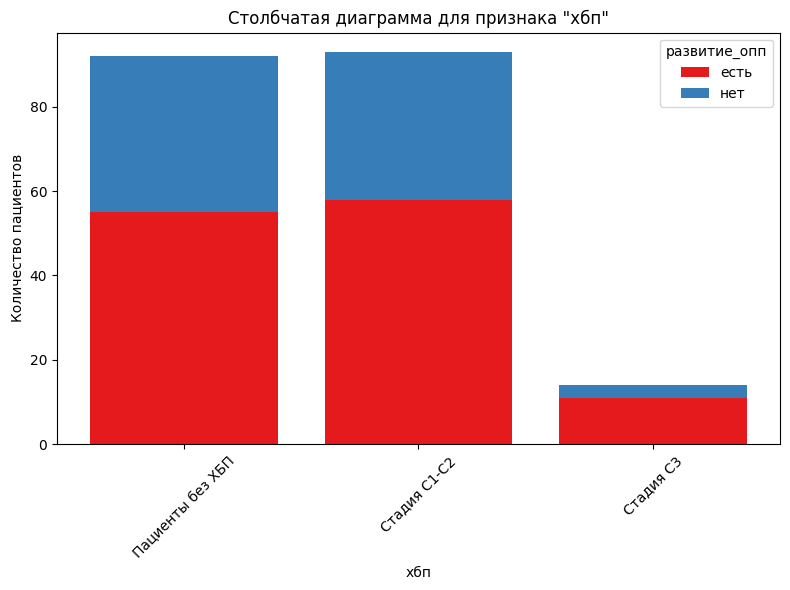

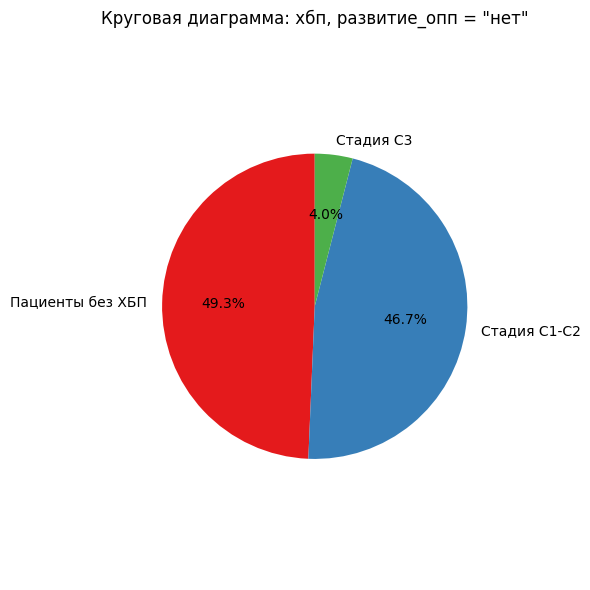

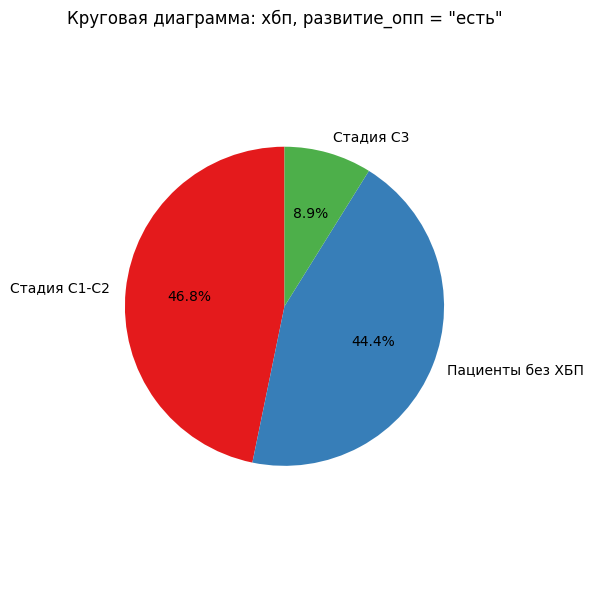

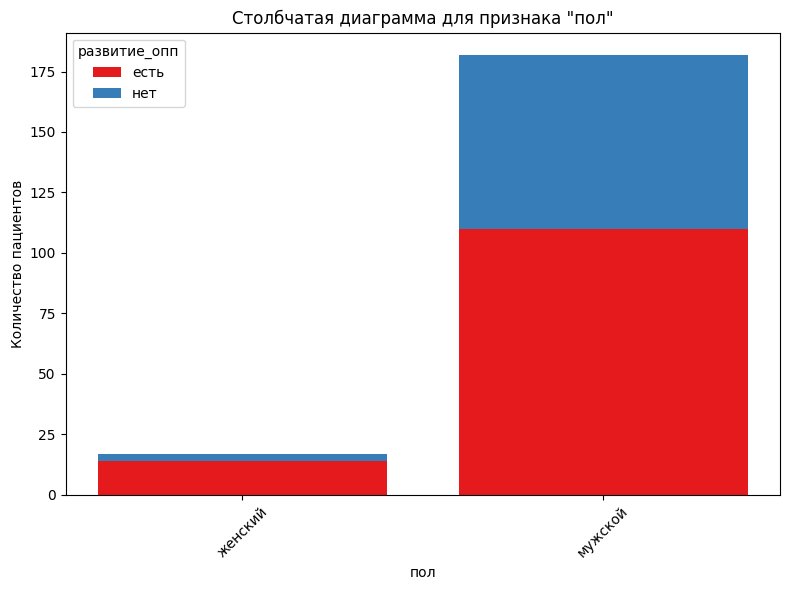

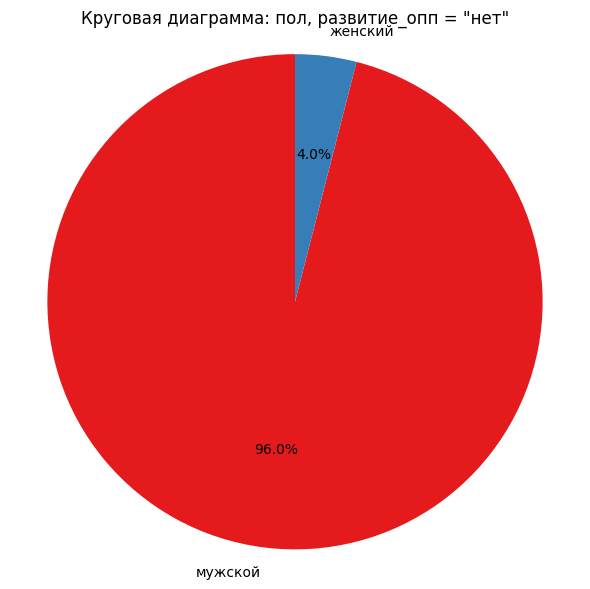

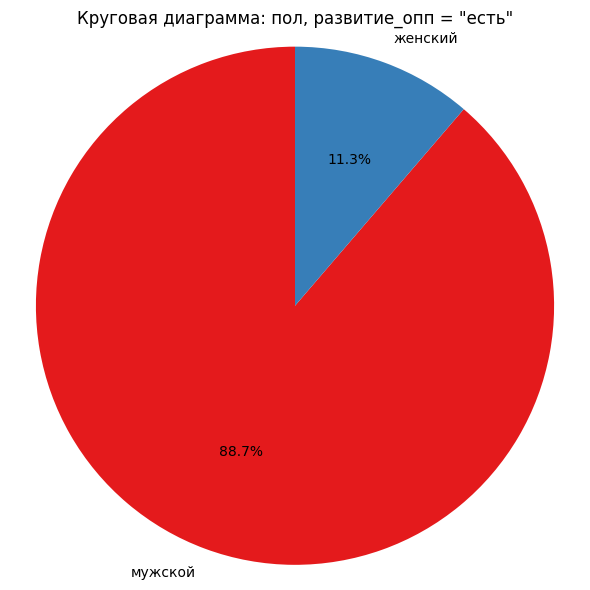

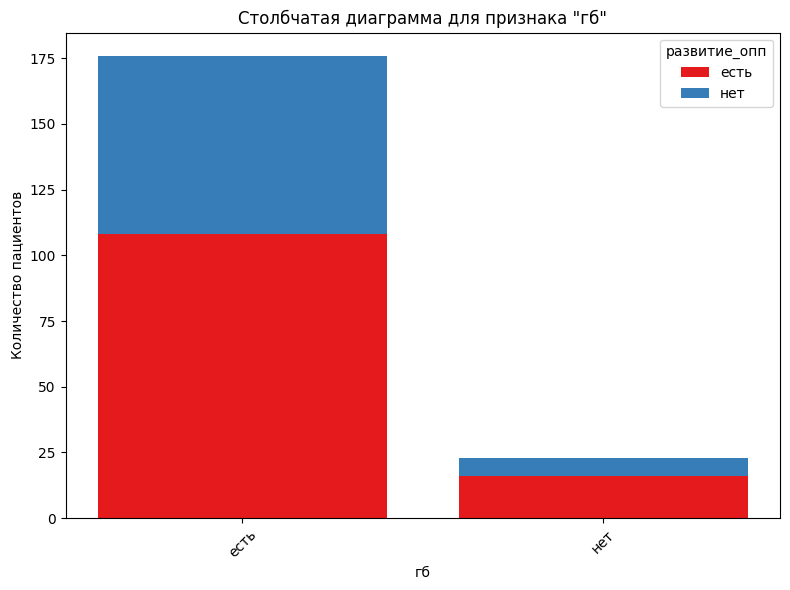

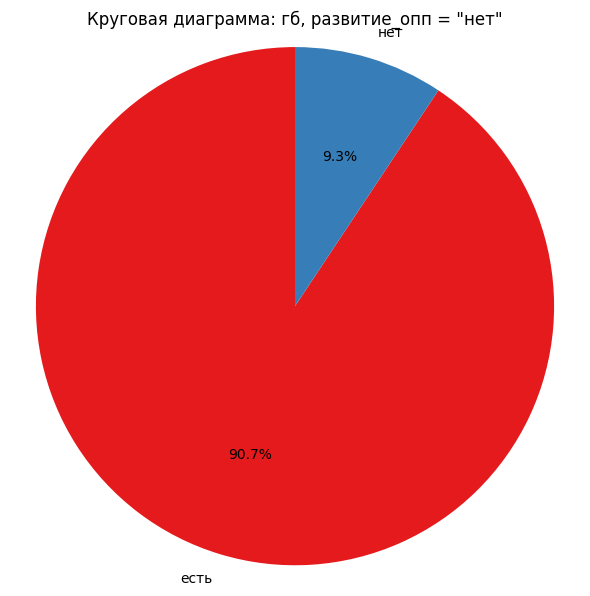

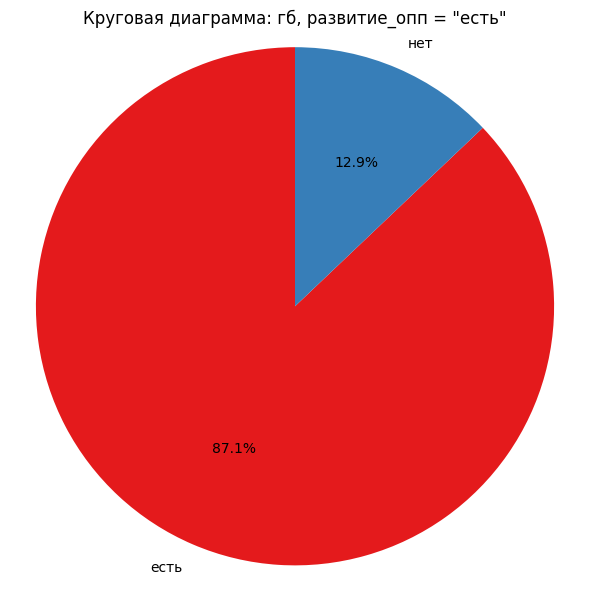

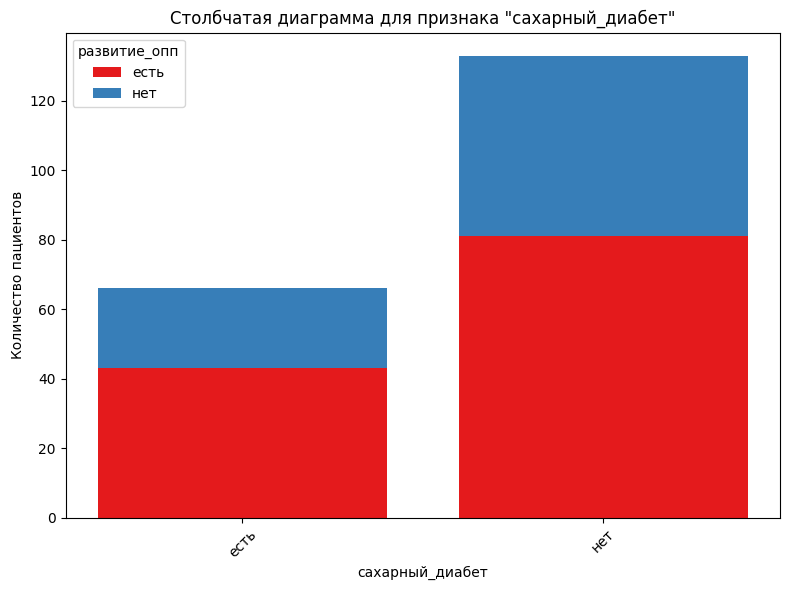

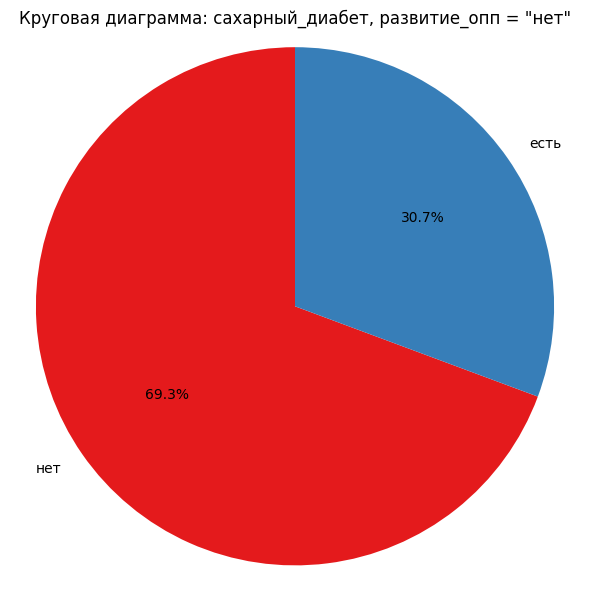

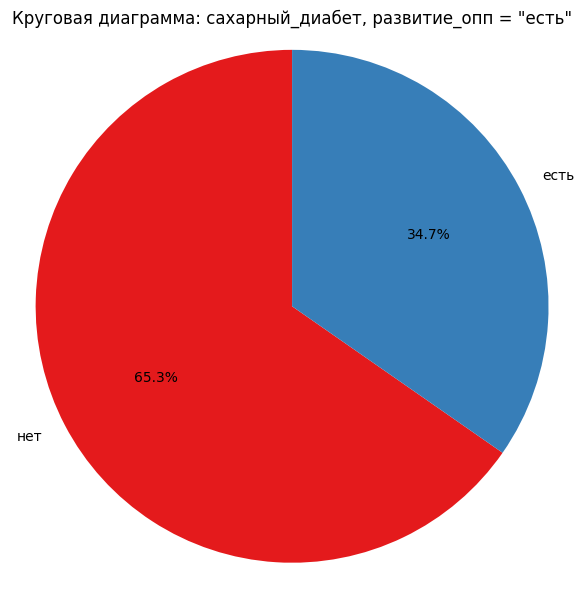

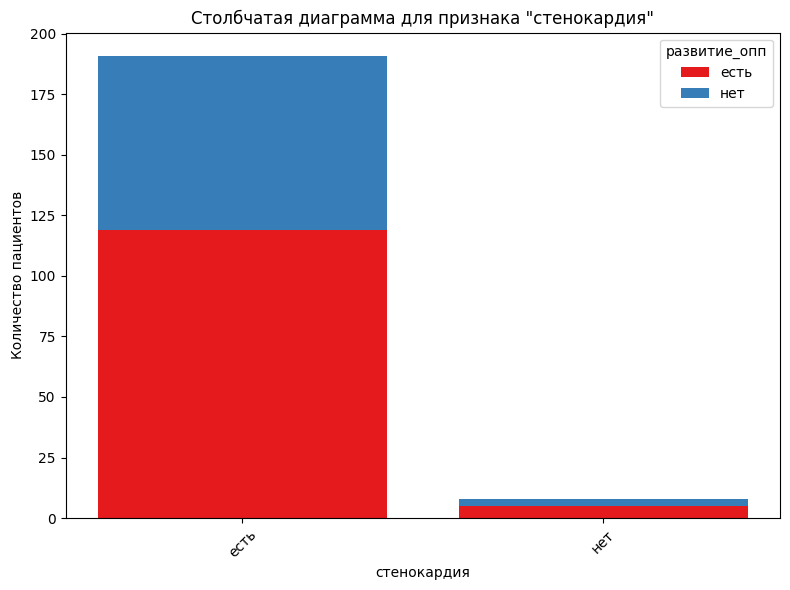

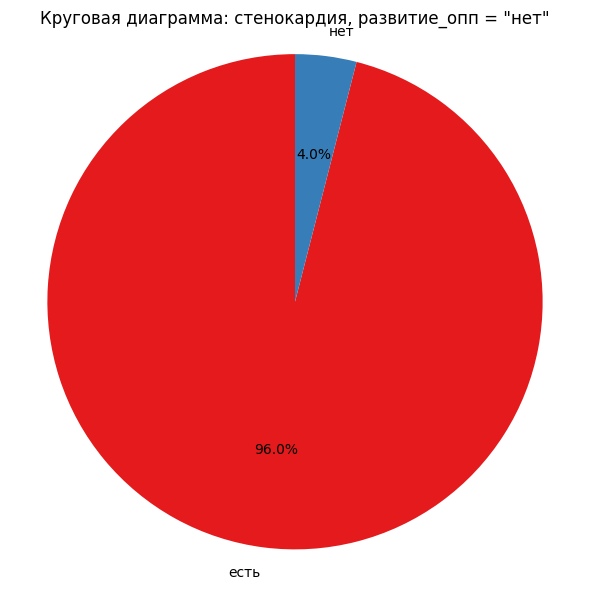

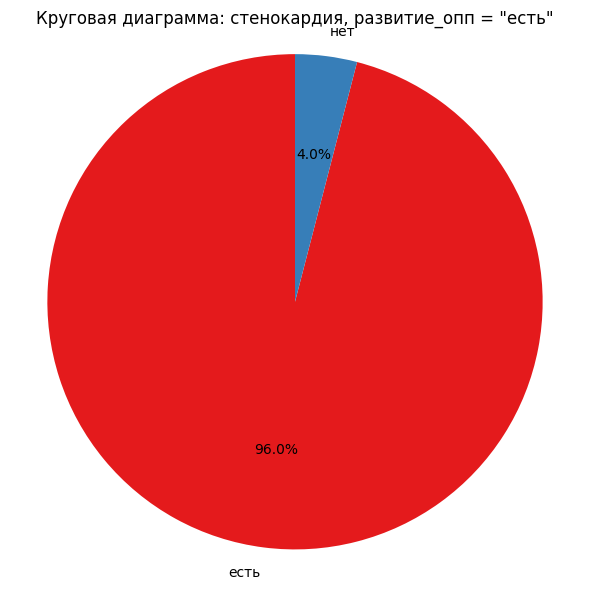

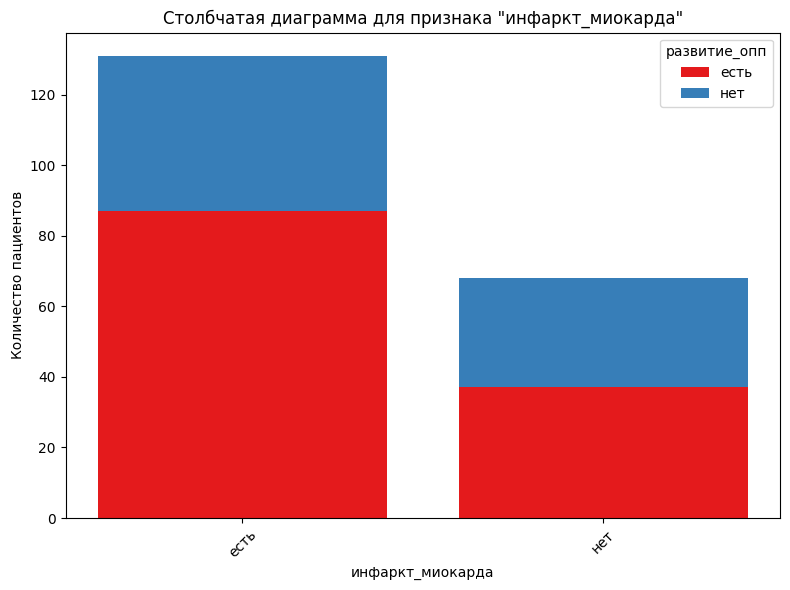

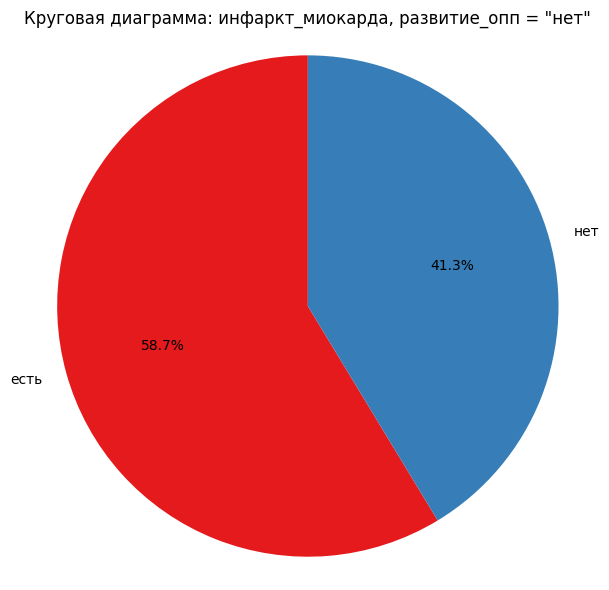

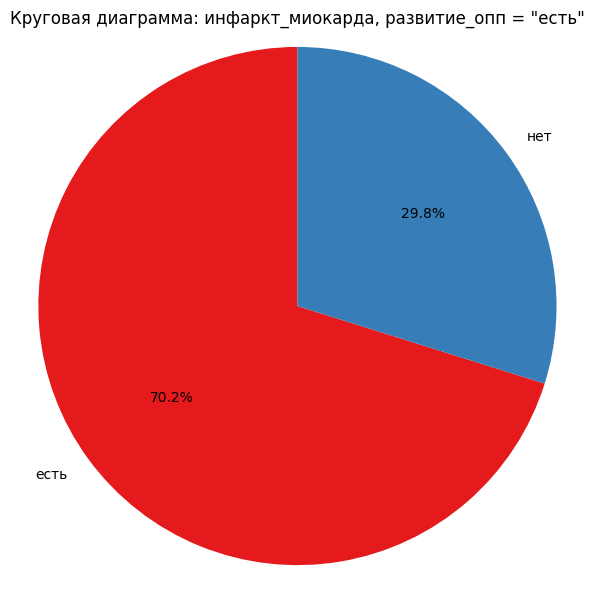

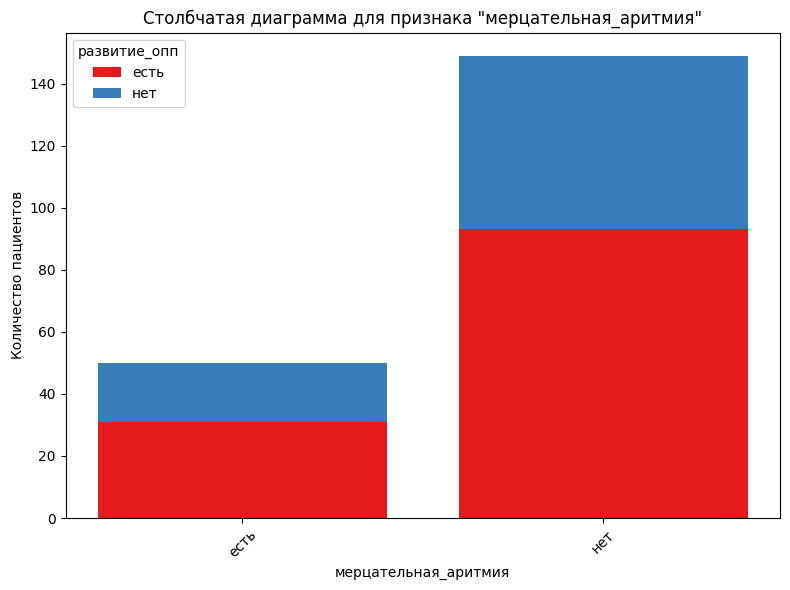

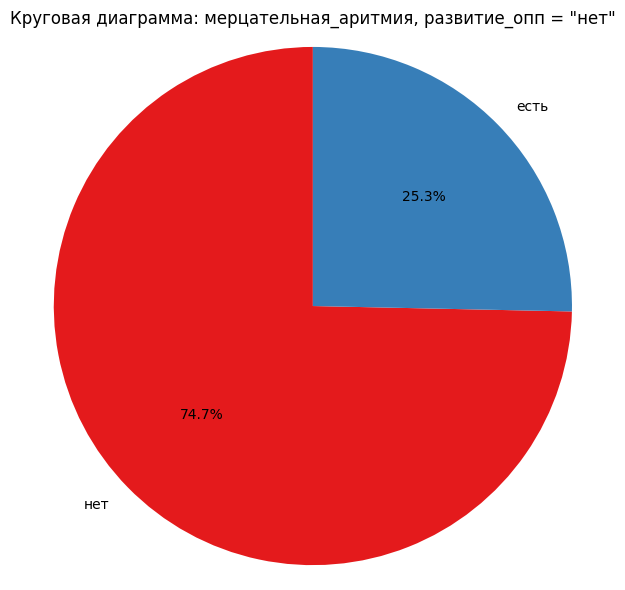

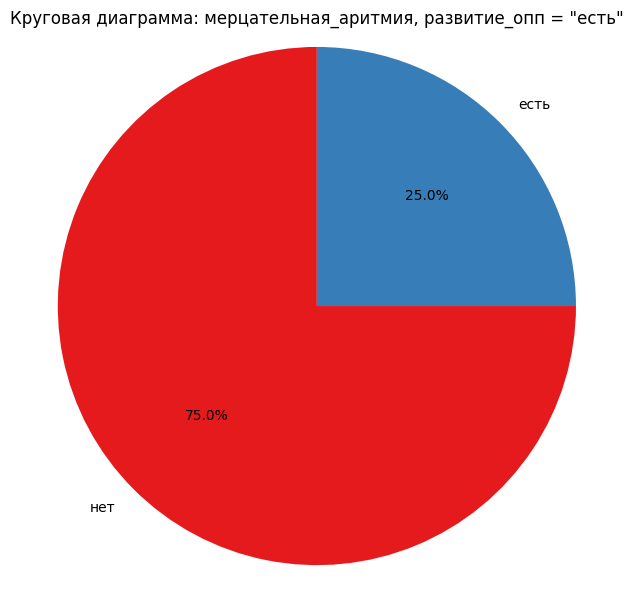

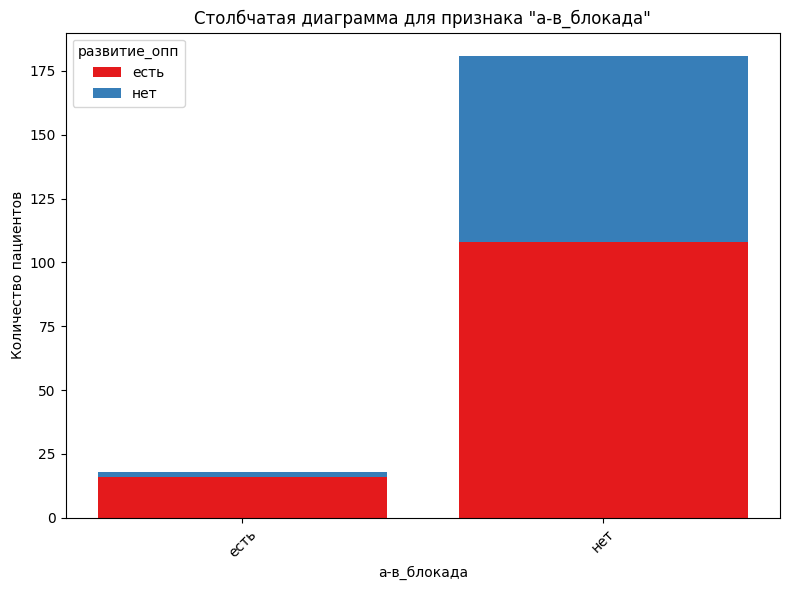

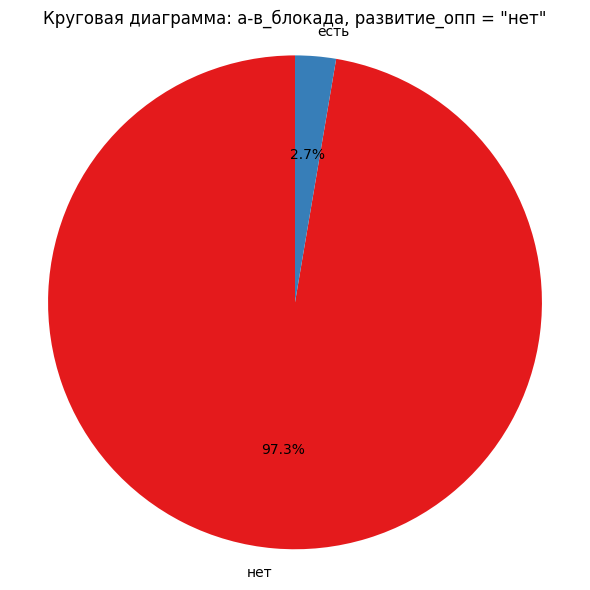

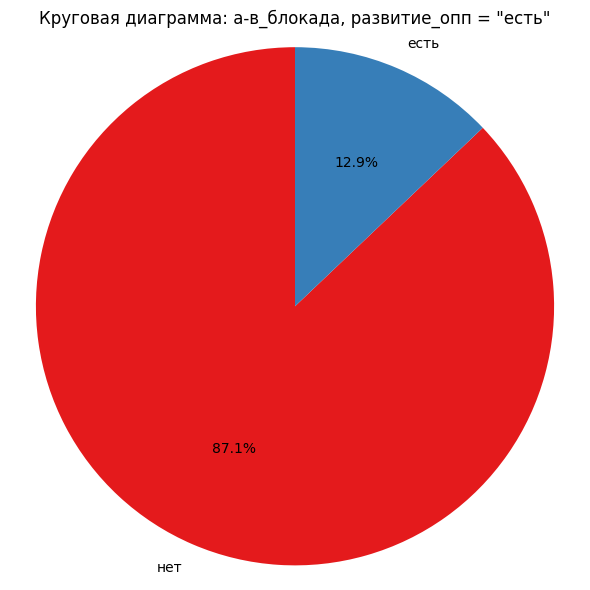

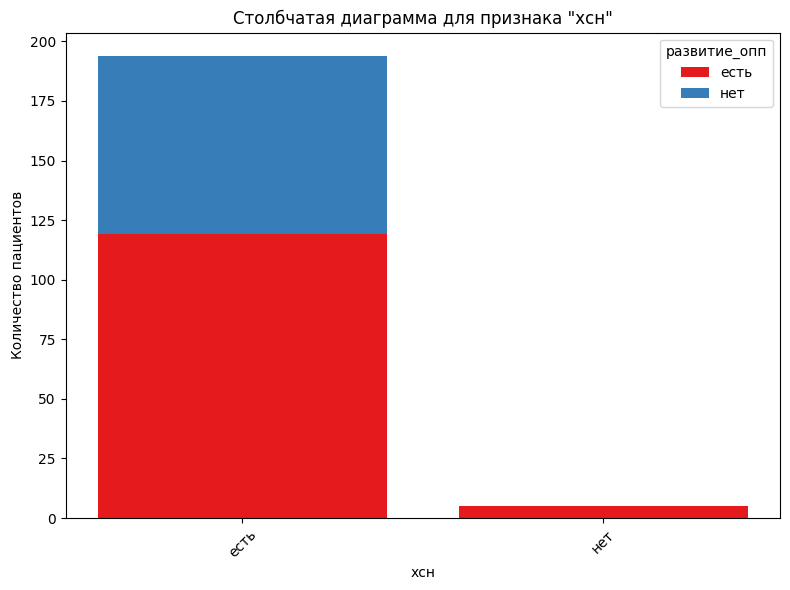

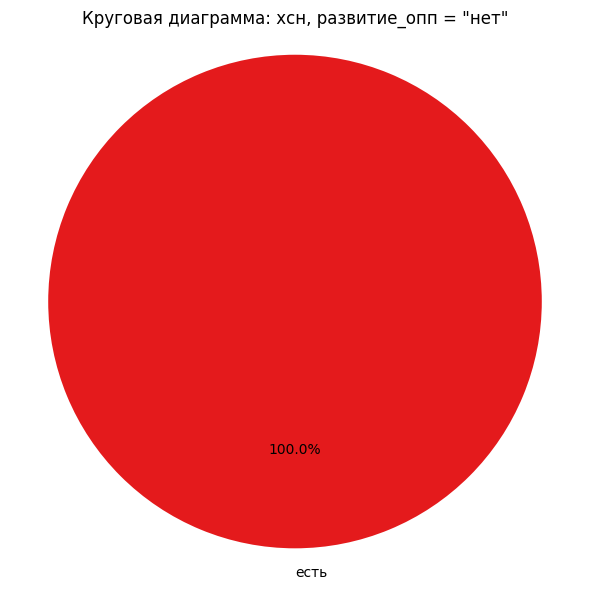

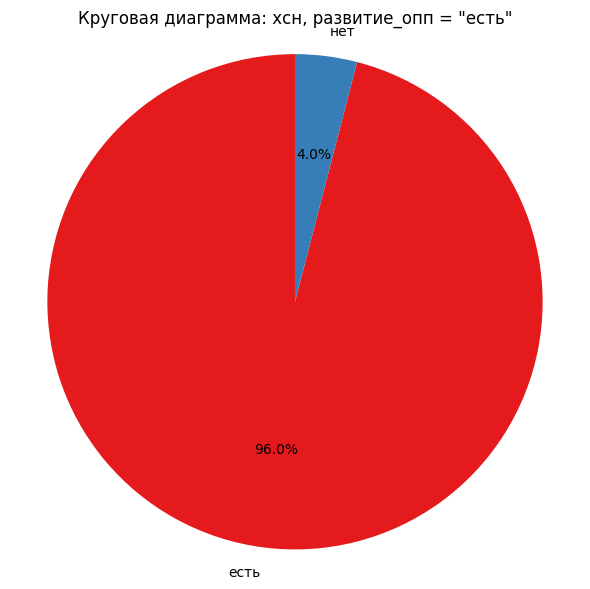

In [3]:
cat_cols = [
    'хбп', 'пол', 'гб', 'сахарный_диабет', 'стенокардия',
    'инфаркт_миокарда', 'мерцательная_аритмия', 'а-в_блокада', 'хсн'
]
target = 'развитие_опп'

# Строим графики
for feature in cat_cols:
    # Смотрим на распределение категориальных признаков по целевой
    grouped = df.groupby([feature, target]).size().unstack(fill_value=0)

    # Простой способ построения столбчатых диаграмм (stacked)
    plt.figure(figsize=(8, 6))
    bottom = [0] * len(grouped)
    colors = sns.color_palette('Set1', n_colors=len(grouped.columns))

    for idx, col in enumerate(grouped.columns):
        plt.bar(
            grouped.index.astype(str),
            grouped[col],
            bottom=bottom,
            label=str(col),
            color=colors[idx]
        )
        bottom = [a + b for a, b in zip(bottom, grouped[col])]

    plt.title(f'Столбчатая диаграмма для признака "{feature}"')
    plt.xlabel(feature)
    plt.ylabel('Количество пациентов')
    plt.legend(title=target)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Круговые диаграммы по значениям категориальной переменной
    unique_values = df[target].unique()
    colors = sns.color_palette('Set1')

    for i in unique_values:
        plt.figure(figsize=(6, 6))

        # Подсчёт значений
        value_counts = df[df[target] == i][feature].value_counts()

        # Построение круговой диаграммы
        plt.pie(
            value_counts.values,
            labels=value_counts.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors[:len(value_counts)]
        )

        plt.title(f'Круговая диаграмма: {feature}, развитие_опп = "{i}"')
        plt.axis('equal')
        plt.tight_layout()

### Итоговые наблюдения:

- **АВ-блокада**: среди пациентов с ОПП доля тех, у кого диагностирована АВ-блокада, заметно выше, чем среди тех, у кого ОПП не развилось. Это может говорить о наличии зависимости.

- **Гипертония (ГБ)**: разница между группами минимальна — чуть больше случаев ГБ у пациентов без ОПП. Вероятнее всего, прямой связи нет.

- **Инфаркт миокарда (ОИМ)**: существенное различие между группами — инфаркт в прошлом чаще встречается у пациентов с ОПП. Можно предположить наличие прямой зависимости.

- **Мерцательная аритмия**: различие между группами составляет менее 0.5%. Вероятнее всего, аритмия и ОПП не связаны.

- **Пол**: (согласно коду анализа ниже) частота развития ОПП у женщин выше, чем у мужчин — возможно, пол влияет на риск.

- **Стенокардия**: различий между группами нет совсем. Признак, скорее всего, не информативен в контексте ОПП.

- **ХБП (хроническая болезнь почек)**: общая структура по подгруппам без ХБП и с ХБП стадий С1–С2 примерно одинаковая. Но стадия С3 встречается почти в 2 раза чаще среди пациентов с ОПП. Возможно, есть связь именно с прогрессирующей ХБП.

- **ХСН (хроническая сердечная недостаточность)**: почти все случаи ХСН — у пациентов без ОПП; с ОПП — только 4%. Разница может объясняться случайным распределением в выборке.

- **Сахарный диабет**: доли почти одинаковые, но у пациентов с ОПП диабет чуть чаще. Возможно, слабая связь есть — СД потенциально влияет на функцию почек.

---

### Гипотезы о зависимости с ОПП:

#### Наиболее вероятные связи:

1. **АВ-блокада** повышает риск развития ОПП.  
2. **Инфаркт миокарда** — сильный фактор риска для ОПП.  
3. **Пол (женский)** — женщины чаще сталкиваются с ОПП, чем мужчины.  
4. **ХБП С3** может быть напрямую связана с развитием ОПП.  

#### Слабые или возможные связи:

- **ХСН** — ОПП реже возникает у пациентов с ХСН, но причина, возможно, в смещённой выборке.  
- **Сахарный диабет** — небольшое превышение среди пациентов с ОПП. Может быть слабая связь.  
- **ГБ** — немного чаще встречается у пациентов без ОПП. Вероятно, это не фактор риска.  
- **Мерцательная аритмия** — почти иденичная частота в обеих группах. Связи нет.  

#### Отсутствие различий:

- **Стенокардия** — полностью равномерное распределение между группами. Связи с ОПП не обнаружено.

---

#### **Вывод**:
к основным потенциальным факторам риска ОПП можно отнести **АВ-блокаду, инфаркт миокарда, женский пол и ХБП С3**. Также стоит обратить внимание на **сахарный диабет** как возможный фактор слабого влияния.


### Анализ гипотез статистическими методами:

In [5]:
# Признаки для анализа
hyp_features = ['хбп', 'пол', 'сахарный_диабет', 'инфаркт_миокарда', 'а-в_блокада']

# Функция для расчёта Cramér’s V
def cramers_v(conf_matrix):
    chi2, _, _, _ = chi2_contingency(conf_matrix)
    n = conf_matrix.values.sum()
    phi2 = chi2 / n
    r, k = conf_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Анализ связи каждого признака с целевой переменной
# H0 для каждого теста - связь не подтверждается или есть слабая
# H1 (альтернативная) - есть хотя бы умеренная связь переменной feature из hyp_features с риском развития ОПП
# проверяем силу связи по крамеру и ее значимость через p-value. Нас интересуют только умеренные и сильные связи, подтвержденные p-value.


def full_test(df, target, feature):
    print("=" * 50)
    print(f"Признак: {feature}")

    contingency = pd.crosstab(df[feature], df[target])
    chi2, p_value, dof, _ = chi2_contingency(contingency)
    v = cramers_v(contingency)

    print("\nСводная таблица частот:")
    print(contingency)

    print(f"\nРезультаты χ²-критерия:")
    print(f"  χ² = {chi2:.2f}")
    print(f"  p-value = {p_value:.4f}")
    print(f"  степени свободы = {dof}")

    print(f"\nКоэффициент связи Cramér’s V: {v:.3f}")

    # Интерпретация силы связи
    if v < 0.1:
        strength = "слабая связь"
    elif v < 0.3:
        strength = "умеренная связь"
    else:
        strength = "сильная связь"
    print(f"Интерпретация: {strength}")

    # Проверка статистической значимости
    if p_value < 0.05:
        print("Вывод: связь статистически значимая (p < 0.05)")
    else:
        print("Вывод: связь статистически незначимая (p ≥ 0.05)")


for feature in hyp_features:
  full_test(df, target, feature)


Признак: хбп

Сводная таблица частот:
развитие_опп      есть  нет
хбп                        
Пациенты без ХБП    55   37
Стадия C1-C2        58   35
Стадия С3           11    3

Результаты χ²-критерия:
  χ² = 1.83
  p-value = 0.4012
  степени свободы = 2

Коэффициент связи Cramér’s V: 0.096
Интерпретация: слабая связь
Вывод: связь статистически незначимая (p ≥ 0.05)
Признак: пол

Сводная таблица частот:
развитие_опп  есть  нет
пол                    
женский         14    3
мужской        110   72

Результаты χ²-критерия:
  χ² = 2.31
  p-value = 0.1282
  степени свободы = 1

Коэффициент связи Cramér’s V: 0.108
Интерпретация: умеренная связь
Вывод: связь статистически незначимая (p ≥ 0.05)
Признак: сахарный_диабет

Сводная таблица частот:
развитие_опп     есть  нет
сахарный_диабет           
есть               43   23
нет                81   52

Результаты χ²-критерия:
  χ² = 0.18
  p-value = 0.6694
  степени свободы = 1

Коэффициент связи Cramér’s V: 0.030
Интерпретация: слабая связь


По результатам отвергаем все, кроме связи с а-в блокадой

### Анализ совместных эффектов:

С помощью logreg посмотрим на совместные влияния признаков

In [ ]:
# Импортируем нужные библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Исходные данные
columns_used = ['а-в_блокада', 'инфаркт_миокарда', 'пол', 'хбп', 'сахарный_диабет']
label = 'развитие_опп'

# Отделим признаки и целевую переменную
X_raw = df[columns_used]
y_raw = df[label]

# Создаём трансформер для one-hot кодирования всех признаков
encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', dtype=int), columns_used)
    ],
    remainder='drop'
)

# Создаём модель
pipeline = make_pipeline(
    encoder,
    LogisticRegression(solver='liblinear')
)

# Обучаем модель
pipeline.fit(X_raw, y_raw)

# Выводим коэффициенты
model = pipeline.named_steps['logisticregression']
encoded_feature_names = pipeline.named_steps['columntransformer'].get_feature_names_out()
coef_df = pd.DataFrame({
    'Признак': encoded_feature_names,
    'Коэффициент': model.coef_[0]
})

print("Коэффициенты логистической регрессии:\n")
print(coef_df.to_string(index=False))

Коэффициенты логистической регрессии:

                  Признак  Коэффициент
     cat__а-в_блокада_нет     0.773974
cat__инфаркт_миокарда_нет     0.443084
         cat__пол_мужской     0.374777
    cat__хбп_Стадия C1-C2    -0.137359
       cat__хбп_Стадия С3    -0.630682
 cat__сахарный_диабет_нет     0.042252


#### Интерпретация коэффициентов логистической регрессии

- Отсутствие а-в блокады увеличивает риск ОПП.
- Отсутствие инфаркта миокарда связано с повышенным риском ОПП.
- Мужчины чаще развивают ОПП, чем женщины.
- ХБП стадии C1-C2 и С3 снижают риск ОПП.
- Сахарный диабет не влияет на риск ОПП.


#### Дополнительные гипотезы о влиянии факторов на развитие ОПП

1. Одновременное наличие а-в блокады и инфаркта миокарда увеличивает риск ОПП.
2. Мужчины с сахарным диабетом чаще болеют ОПП, чем другие группы.
3. ХБП стадии С3 вместе с а-в блокадой повышают риск ОПП.
4. Инфаркт миокарда и сахарный диабет вместе увеличивают вероятность ОПП.
5. Мужской пол и ХБП стадии С3 влияют на развитие ОПП в сочетании.


Таблица сопряжённости: а-в_блокада и инфаркт_миокарда
развитие_опп                  есть  нет
а-в_блокада инфаркт_миокарда           
есть        есть                 8    2
            нет                  8    0
нет         есть                79   42
            нет                 29   31

χ² = 11.620, p-value = 0.0088


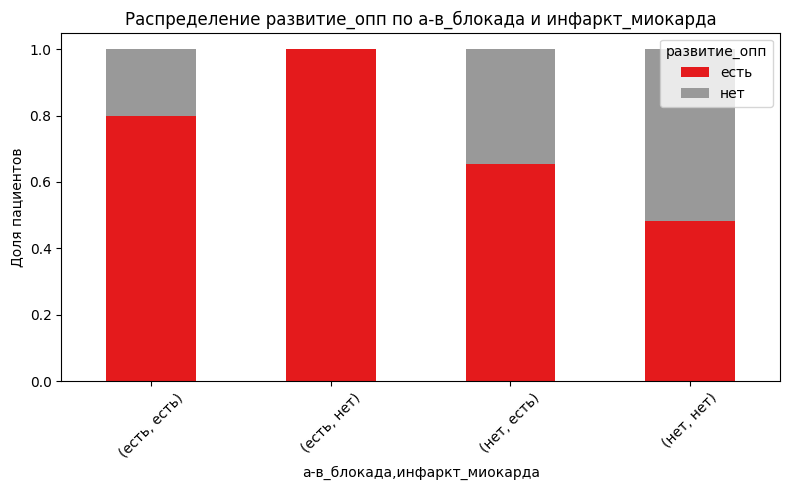


------------------------------------------------------------

Таблица сопряжённости: пол и сахарный_диабет
развитие_опп             есть  нет
пол     сахарный_диабет           
женский есть                5    1
        нет                 9    2
мужской есть               38   22
        нет                72   50

χ² = 3.502, p-value = 0.3205


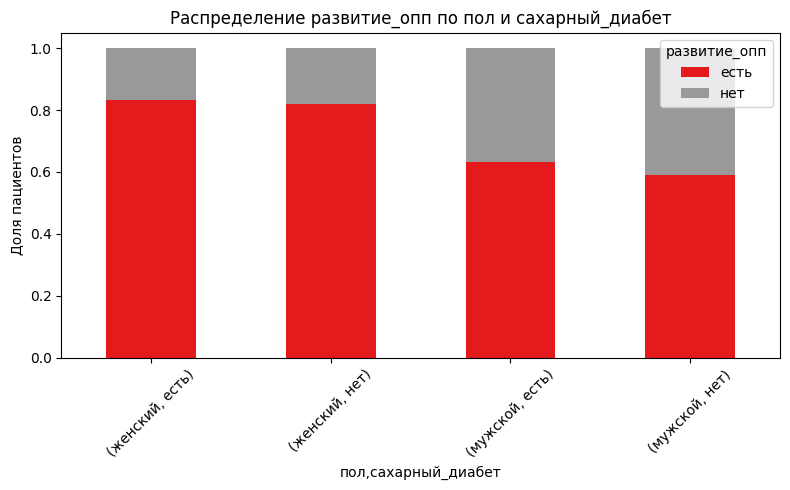


------------------------------------------------------------

Таблица сопряжённости: хбп и а-в_блокада
развитие_опп                  есть  нет
хбп              а-в_блокада           
Пациенты без ХБП есть            7    1
                 нет            48   36
Стадия C1-C2     есть            7    1
                 нет            51   34
Стадия С3        есть            2    0
                 нет             9    3

χ² = 7.504, p-value = 0.1858


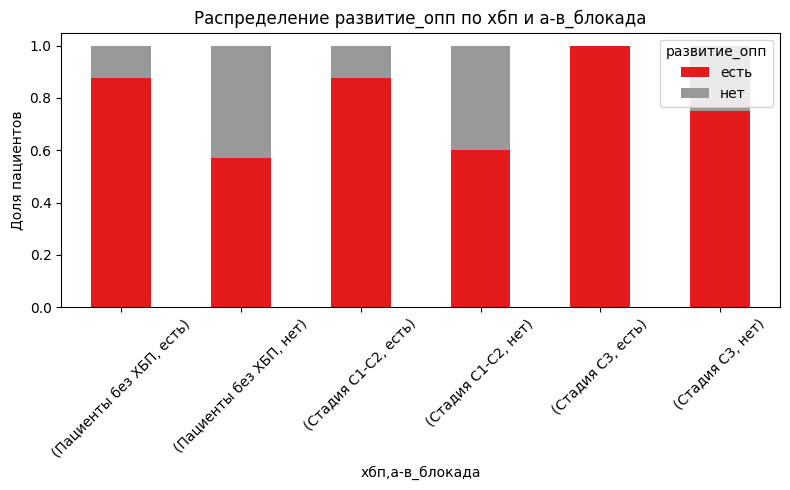


------------------------------------------------------------

Таблица сопряжённости: инфаркт_миокарда и сахарный_диабет
развитие_опп                      есть  нет
инфаркт_миокарда сахарный_диабет           
есть             есть               32   16
                 нет                55   28
нет              есть               11    7
                 нет                26   24

χ² = 3.215, p-value = 0.3597


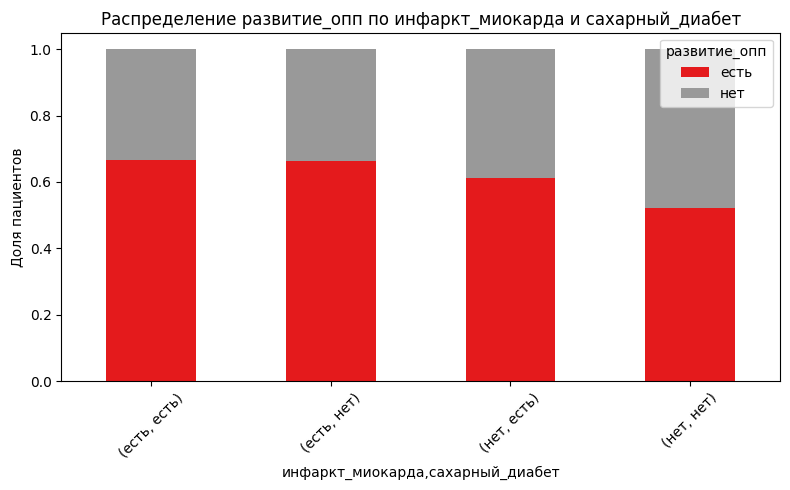


------------------------------------------------------------

Таблица сопряжённости: пол и хбп
развитие_опп              есть  нет
пол     хбп                        
женский Пациенты без ХБП     4    1
        Стадия C1-C2         7    2
        Стадия С3            3    0
мужской Пациенты без ХБП    51   36
        Стадия C1-C2        51   33
        Стадия С3            8    3

χ² = 4.501, p-value = 0.4797


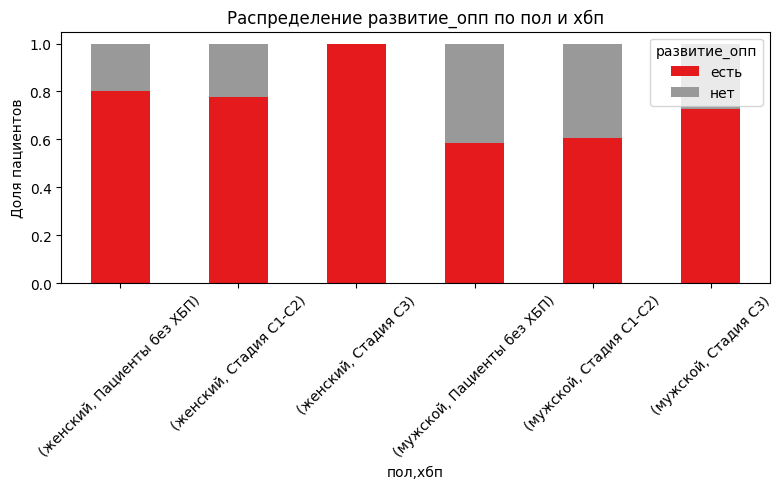


------------------------------------------------------------

Логистическая регрессия с взаимодействиями для признаков: пол и сахарный_диабет
                                  Признак  Коэффициент
                         cat__пол_мужской     0.386502
                 cat__сахарный_диабет_нет    -0.228207
cat__пол_мужской*cat__сахарный_диабет_нет     0.395990


Логистическая регрессия с взаимодействиями для признаков: хбп и а-в_блокада
                                   Признак  Коэффициент
                     cat__хбп_Стадия C1-C2    -0.322814
                        cat__хбп_Стадия С3    -0.513660
                      cat__а-в_блокада_нет     0.778144
  cat__хбп_Стадия C1-C2*cat__хбп_Стадия С3     0.000000
cat__хбп_Стадия C1-C2*cat__а-в_блокада_нет     0.229389
   cat__хбп_Стадия С3*cat__а-в_блокада_нет    -0.182361




In [ ]:
# Гипотезы для проверки
combined_hyps = [
    ('а-в_блокада', 'инфаркт_миокарда'),
    ('пол', 'сахарный_диабет'),
    ('хбп', 'а-в_блокада'),
    ('инфаркт_миокарда', 'сахарный_диабет'),
    ('пол', 'хбп')
]

target = 'развитие_опп'

def chi2_test_and_plot(feature1, feature2, df):
    ct = pd.crosstab(index=[df[feature1], df[feature2]], columns=df[target])
    print(f"Таблица сопряжённости: {feature1} и {feature2}\n{ct}\n")

    chi2, p, _, _ = chi2_contingency(ct)
    print(f"χ² = {chi2:.3f}, p-value = {p:.4f}")

    # Визуализация
    prop_ct = ct.div(ct.sum(axis=1), axis=0)
    prop_ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set1')
    plt.title(f'Распределение {target} по {feature1} и {feature2}')
    plt.ylabel('Доля пациентов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n" + "-"*60 + "\n")

# Проверяем гипотезы с помощью χ²-теста и визуализации
for f1, f2 in combined_hyps:
    chi2_test_and_plot(f1, f2, df)

# Функция для обучения логистической регрессии с взаимодействием двух признаков
def logistic_regression_interaction(f1, f2, df, target):
    # Формируем признаки и целевую переменную
    X = df[[f1, f2]]
    y = df[target]

    # One-hot кодирование признаков с drop_first=True для избежания дамми-ловушки
    encoder = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(drop='first', dtype=int), [f1, f2])],
        remainder='drop'
    )

    X_encoded = encoder.fit_transform(X)
    feature_names = encoder.get_feature_names_out()

    # Добавим взаимодействия между всеми dummy-признаками
    import numpy as np
    from scipy.sparse import csr_matrix, hstack

    X_encoded = csr_matrix(X_encoded)  # чтобы гарантировать формат sparse
    inter_cols = []
    inter_data = []
    for i in range(X_encoded.shape[1]):
        for j in range(i+1, X_encoded.shape[1]):
            inter_col = X_encoded[:, i].multiply(X_encoded[:, j])
            inter_cols.append(inter_col)

    if inter_cols:
        X_interactions = hstack(inter_cols)
        X_final = hstack([X_encoded, X_interactions])
    else:
        X_final = X_encoded

    # Обучаем логистическую регрессию
    model = LogisticRegression(solver='liblinear')
    model.fit(X_final, y)

    # Выводим коэффициенты
    coefs = model.coef_[0]
    base_names = list(feature_names)
    interaction_names = []
    for i in range(len(base_names)):
        for j in range(i+1, len(base_names)):
            interaction_names.append(base_names[i] + "*" + base_names[j])

    all_names = base_names + interaction_names

    coef_df = pd.DataFrame({
        'Признак': all_names,
        'Коэффициент': coefs
    })

    print(f"Логистическая регрессия с взаимодействиями для признаков: {f1} и {f2}")
    print(coef_df.to_string(index=False))
    print("\n" + "="*60 + "\n")

# Проверяем взаимодействия для нескольких гипотез, где они клинически интересны
logistic_regression_interaction('пол', 'сахарный_диабет', df, target)
logistic_regression_interaction('хбп', 'а-в_блокада', df, target)


#### Интерпретация результатов анализа гипотез

**1. а-в_блокада и инфаркт_миокарда:**  
В группе с ОПП больше пациентов с обеими патологиями. Связь есть, но небольшое количество в некоторых категориях ограничивает точность.

**2. пол и сахарный_диабет:**  
Логистическая регрессия показывает, что мужчины и отсутствие диабета влияют на вероятность ОПП. Взаимодействие признаков указывает, что эффект пола меняется в зависимости от наличия диабета.

**3. хбп и а-в_блокада:**  
Основное влияние оказывают наличие а-в блокады и стадии ХБП. Взаимодействия между стадиями ХБП и а-в блокадой есть, но слабы. Коэффициенты отрицательны для стадий ХБП, положительны для отсутствия блокады.

**4. инфаркт_миокарда и сахарный_диабет:**  
В группах с инфарктом и диабетом выше число пациентов с ОПП, что указывает на взаимное влияние факторов.

**5. пол и хбп:**  
Женщины и разные стадии ХБП встречаются в разных пропорциях у пациентов с ОПП, что может указывать на сложное взаимодействие, требующее дальнейшего анализа.

---

**Общие выводы:**  
- Наличие а-в блокады и инфаркта повышает риск развития ОПП.  
- Пол и сахарный диабет взаимосвязаны и влияют на риск совместно.  
- Стадии ХБП и а-в блокада влияют на ОПП, есть слабое взаимодействие.  
- Инфаркт и диабет вместе увеличивают риск.  
- Взаимодействия признаков важны для понимания комплексных факторов риска.
